# Replacing Covid Tracking Project Data

- 07/11/21

>NOTE: SEE FINAL WORKFLOW IN "`Replacing Covid Tracking Project - Simplified Workflow.ipynb` and the final script in `data_acquisition.py`

## Goal

- As of 03/07/21 the Covid Tracking Project has stopped collecting new data. 
    - https://covidtracking.com/data
    - This was the primary backbone of my modeling and dashboard and needs to be replaced/ 
    - While I already have an alternative coronavirus source for time series from Kaggle, I want to have the ICU capacity and hospitalization records.
    
    
- Federal Data: 
    - Covid Tracking Project provides info on alternative data sources. https://covidtracking.com/analysis-updates/federal-covid-data-101-how-to-find-data
        - related posts: https://covidtracking.com/analysis-updates/category/federal-covid-data-101
    - They also provide a simple approach for the general public: https://covidtracking.com/analysis-updates/simple-covid-data

- COVID-19 hospitalization data training:
    - Video: https://www.youtube.com/watch?v=TGAHQt1Rkf8
    - Presentaation (my copy): https://docs.google.com/presentation/d/1p5XNS7b9_R40zaBgC5EiWvP1Vs7UJiAXPQ3WP-U9PjI/edit?usp=sharing

# The Code

## Existing Code/Data

In [98]:
# !pip install -U fsds
from fsds.imports import *

import os
pd.set_option('display.max_columns',0)

In [99]:
## Appending folder with functions
%load_ext autoreload 
%autoreload 2
# import sys
# sys.path.append('.')

import functions as fn
# help(fn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
## original class for using The Covid Tracking Project API
covid = fn.CovidTrackingProject(verbose=True)
covid

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "New Data/states_metadata.csv"
ERROR
	- File saved as: "New Data/us.csv"
	- File saved as: "New Data/states.csv"
states


------------------------------------------------------------
[i] CovidTrackingProject Contents:
------------------------------------------------------------

METHODS:
	download_state_daily
	download_state_meta
	download_us_daily
	get_csv_save_load
	get_df
	get_group_ts
	help

ATTRIBUTES
	base_folder
	base_url
	columns
	columns_us
	df
	df_states
	df_us
	urls

In [101]:
covid.df

states


,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,hospitalizedDischarged,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-07,AK,56886.0,NaN,NaN,NaN,totalTestsViral,1731628.0,33.0,1293.0,NaN,NaN,2.0,NaN,NaN,3/5/2021 03:59,2021-03-05T03:59:00Z,03/04 22:59,305.0,1293.0,NaN,2021-03-05T03:59:00Z,1731628.0,68693.0,1660758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,56886,0,56886,NaN,0,0,dc4bccd4bb885349d7e94d6fed058e285d4be164,0,0,0,0,0,NaN
2021-03-07,AL,499819.0,107742.0,1931711.0,NaN,totalTestsPeopleViral,2323788.0,494.0,45976.0,NaN,2676.0,NaN,1515.0,295690.0,3/7/2021 11:00,2021-03-07T11:00:00Z,03/07 06:00,10148.0,45976.0,NaN,2021-03-07T11:00:00Z,NaN,NaN,NaN,392077.0,7963.0,2185.0,NaN,2323788.0,NaN,NaN,NaN,119757.0,NaN,NaN,NaN,NaN,NaN,NaN,1,408,2087,2431530,2347,2431530,NaN,-1,0,997207b430824ea40b8eb8506c19a93e07bc972e,0,0,0,0,0,NaN
2021-03-07,AR,324818.0,69092.0,2480716.0,NaN,totalTestsViral,2736442.0,335.0,14926.0,141.0,NaN,65.0,1533.0,315517.0,3/7/2021 00:00,2021-03-07T00:00:00Z,03/06 19:00,5319.0,14926.0,NaN,2021-03-07T00:00:00Z,2736442.0,NaN,2480716.0,255726.0,4308.0,1011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,481311.0,81803.0,NaN,NaN,5,165,3267,2805534,3380,2805534,NaN,22,11,50921aeefba3e30d31623aa495b47fb2ecc72fae,0,0,0,0,0,NaN
2021-03-07,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/1/2020 00:00,2020-12-01T00:00:00Z,11/30 19:00,0.0,NaN,NaN,2020-12-01T00:00:00Z,2140.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,0,0,2140,0,2140,NaN,0,0,f77912d0b80d579fbb6202fa1a90554fc4dc1443,0,0,0,0,0,NaN
2021-03-07,AZ,826454.0,56519.0,3073010.0,NaN,totalTestsViral,7908105.0,963.0,57907.0,273.0,NaN,143.0,NaN,NaN,3/7/2021 00:00,2021-03-07T00:00:00Z,03/06 19:00,16328.0,57907.0,118932.0,2021-03-07T00:00:00Z,7908105.0,NaN,NaN,769935.0,14403.0,1925.0,NaN,3842945.0,580569.0,NaN,NaN,444089.0,NaN,NaN,NaN,NaN,NaN,NaN,4,1335,13678,3899464,45110,3899464,NaN,5,44,0437a7a96f4471666f775e63e86923eb5cbd8cdf,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-17,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,NaN,0,0,7cefac6b3681020741ca30f45399a7b22f2e45b4,0,0,0,0,0,NaN
2020-01-16,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,NaN,0,0,650501e005a5ee86d93c5f32dda56735ea2af967,0,0,0,0,0,NaN
2020-01-15,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,0,0,0,NaN,0,0,4987e61aad88182abfe641033b597304c2153d4f,0,0,0,0,0,NaN


## Columns to Find

#### Columns to find from the covid tracking project dataset: 

- "hospitalizedCurrently"/"hospitalizedCumulative"
- "inIcuCurrently","inIcuCumulative"
- "onVentilatorCurrently","onVentilatorCumulative"

# New Data Sources

## Kaggle

### ❌ Covid19-US JHU Data by County + Demographics

- https://www.kaggle.com/headsortails/covid19-us-county-jhu-data-demographics

- **NOTE: after downloading it seems to just be county demographics, not any time series covid stats**

In [102]:
# !kaggle datasets download -d headsortails/covid19-us-county-jhu-data-demographics

In [103]:
# import zipfile
# us_county_jhu_zip = zipfile.ZipFile('covid19-us-county-jhu-data-demographics.zip')
# us_county_jhu_zip.namelist()

In [104]:
# us_county_jhu_zip.extract('us_county.csv')
# us_county = pd.read_csv("us_county.csv")
# us_county

In [105]:
# us_county_jhu_zip.extract('covid_us_county.csv')
# covid_us_county = pd.read_csv("covid_us_county.csv")
# covid_us_county

# **Cleaning File Organization/Downloading** 08/12

### Covid-19 Data From Johns Hopkins University

- https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university
- Comes with CONVENIENT_ files and RAW_ files.

In [106]:
## Specifying data storage folders
fpath_raw = r"data_raw"
fpath_clean = r"data/"
[os.makedirs(fpath,exist_ok=True) for fpath in [fpath_clean,fpath_raw]];
# sorted(os.listdir())

In [107]:
# !kaggle datasets download  -p "{fpath_raw}" -d antgoldbloom/covid19-data-from-john-hopkins-university -f CONVENIENT_global_confirmed_cases.csv --force
os.system(f"kaggle datasets download  -p {fpath_raw} -d antgoldbloom/covid19-data-from-john-hopkins-university -f CONVENIENT_global_confirmed_cases.csv --force")

0

### Files of Interest

In [108]:
files = ['CONVENIENT_us_metadata.csv','RAW_us_confirmed_cases.csv','RAW_us_deaths.csv']
for file in files:
    print(f"Downloading {file} to {fpath_raw}")
    os.system(f"kaggle datasets download  -p {fpath_raw} -d antgoldbloom/covid19-data-from-john-hopkins-university -f {file} --force")

## Previous Way - Entire Zip Archive

In [109]:
!kaggle datasets download -p "{fpath_raw}" -d antgoldbloom/covid19-data-from-john-hopkins-university

covid19-data-from-john-hopkins-university.zip: Skipping, found more recently modified local copy (use --force to force download)


In [110]:
import zipfile
jhu_data_zip = zipfile.ZipFile(os.path.join(fpath_raw,'covid19-data-from-john-hopkins-university.zip'))
jhu_data_zip.namelist()

['CONVENIENT_global_confirmed_cases.csv',
 'CONVENIENT_global_deaths.csv',
 'CONVENIENT_global_metadata.csv',
 'CONVENIENT_us_confirmed_cases.csv',
 'CONVENIENT_us_deaths.csv',
 'CONVENIENT_us_metadata.csv',
 'RAW_global_confirmed_cases.csv',
 'RAW_global_deaths.csv',
 'RAW_us_confirmed_cases.csv',
 'RAW_us_deaths.csv']

In [111]:
## Files to extract
import os 

files_to_extract = ['RAW_us_confirmed_cases.csv','CONVENIENT_us_confirmed_cases.csv',
                    'RAW_us_deaths.csv','CONVENIENT_us_deaths.csv','CONVENIENT_us_metadata.csv']
for i,file in enumerate(files_to_extract):
    print(f"{i}. {file}")
    jhu_data_zip.extract(file)

0. RAW_us_confirmed_cases.csv
1. CONVENIENT_us_confirmed_cases.csv
2. RAW_us_deaths.csv
3. CONVENIENT_us_deaths.csv
4. CONVENIENT_us_metadata.csv


In [197]:
# import os

# ## raw vs conv cases
# raw_us_cases = pd.read_csv(files_to_extract[0],low_memory=False)
# conv_us_cases = pd.read_csv(files_to_extract[1],low_memory=False)
# display(raw_us_cases.head().style.set_caption('raw_us_cases'),
#        conv_us_cases.head().style.set_caption('conv_us_cases'))

# print('---'*30)

# ## raw vs conv deaths 
# raw_us_deaths = pd.read_csv(files_to_extract[2],low_memory=False)
# conv_us_deaths = pd.read_csv(files_to_extract[3],low_memory=False)
# display(raw_us_deaths.head().style.set_caption('raw_us_deaths'),
#        conv_us_deaths.head().style.set_caption('conv_us_deaths'))

In [198]:
# metadata
conv_metadata = pd.read_csv(files_to_extract[4],low_memory=False)
conv_metadata

,Province_State,Admin2,Population,Lat,Long
0,Alabama,Autauga,55869,32.539527,-86.644082
1,Alabama,Baldwin,223234,30.727750,-87.722071
2,Alabama,Barbour,24686,31.868263,-85.387129
3,Alabama,Bibb,22394,32.996421,-87.125115
4,Alabama,Blount,57826,33.982109,-86.567906
...,...,...,...,...,...
3337,Wyoming,Teton,23464,43.935225,-110.589080
3338,Wyoming,Uinta,20226,41.287818,-110.547578
3339,Wyoming,Unassigned,0,0.000000,0.000000
3340,Wyoming,Washakie,7805,43.904516,-107.680187


### Notes re: kaggle source above

- **The RAW_ files** are closer to what I have been working with already so I will stick with those. 

In [199]:
jhu_data_zip = zipfile.ZipFile(os.path.join(fpath_raw,'covid19-data-from-john-hopkins-university.zip'))
jhu_data_zip.namelist()

['CONVENIENT_global_confirmed_cases.csv',
 'CONVENIENT_global_deaths.csv',
 'CONVENIENT_global_metadata.csv',
 'CONVENIENT_us_confirmed_cases.csv',
 'CONVENIENT_us_deaths.csv',
 'CONVENIENT_us_metadata.csv',
 'RAW_global_confirmed_cases.csv',
 'RAW_global_deaths.csv',
 'RAW_us_confirmed_cases.csv',
 'RAW_us_deaths.csv']

In [200]:
# metadata
file = 'CONVENIENT_us_metadata.csv'
jhu_data_zip.extract(file,path=fpath_raw)
df_metadata = pd.read_csv(os.path.join(fpath_raw,file))
df_metadata

,Province_State,Admin2,Population,Lat,Long
0,Alabama,Autauga,55869,32.539527,-86.644082
1,Alabama,Baldwin,223234,30.727750,-87.722071
2,Alabama,Barbour,24686,31.868263,-85.387129
3,Alabama,Bibb,22394,32.996421,-87.125115
4,Alabama,Blount,57826,33.982109,-86.567906
...,...,...,...,...,...
3337,Wyoming,Teton,23464,43.935225,-110.589080
3338,Wyoming,Uinta,20226,41.287818,-110.547578
3339,Wyoming,Unassigned,0,0.000000,0.000000
3340,Wyoming,Washakie,7805,43.904516,-107.680187


### Adding State Abbreviations

- Adding 2 letter abbrevtions (more appropriate for column name prefix)


In [201]:
state_abbrevs = pd.read_csv('Reference Data/united_states_abbreviations.csv')
state_abbrevs.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [202]:
## Making dicts of Name:Abbrev and Abbrev:Name
state_to_abbrevs_map = dict(zip(state_abbrevs['State'],state_abbrevs['Abbreviation']))
abbrev_to_state_map = dict(zip(state_abbrevs['Abbreviation'],state_abbrevs['State']))

state_to_abbrevs_map.keys()

dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'])

In [203]:
df_metadata.isna().sum()

Province_State    0
Admin2            6
Population        0
Lat               0
Long              0
dtype: int64

In [204]:
## Adding State Abbrevas to kaggle metadata
df_metadata.insert(1,'State_Code',df_metadata['Province_State'].map(state_to_abbrevs_map))
df_metadata[df_metadata['State_Code'].isna()]

,Province_State,State_Code,Admin2,Population,Lat,Long
102,American Samoa,NaN,NaN,55641,-14.2710,-170.1320
338,Diamond Princess,NaN,NaN,0,0.0000,0.0000
572,Grand Princess,NaN,NaN,0,0.0000,0.0000
573,Guam,NaN,NaN,164229,13.4443,144.7937
2123,Northern Mariana Islands,NaN,NaN,55144,15.0979,145.6739
3009,Virgin Islands,NaN,NaN,107268,18.3358,-64.8963


- We do not have corresponding State codes for:
    -'American Samoa',
    'Diamond Princess', 
    'Grand Princess',
    'Guam',
    'Northern Mariana Islands',
    'Virgin Islands'
    
- We will exclude them from the final dataset. 

In [205]:
## Dropping us territories
df_metadata.dropna(subset=['State_Code'], inplace=True)
df_metadata.isna().sum()

Province_State    0
State_Code        0
Admin2            0
Population        0
Lat               0
Long              0
dtype: int64

In [206]:
df_metadata

,Province_State,State_Code,Admin2,Population,Lat,Long
0,Alabama,AL,Autauga,55869,32.539527,-86.644082
1,Alabama,AL,Baldwin,223234,30.727750,-87.722071
2,Alabama,AL,Barbour,24686,31.868263,-85.387129
3,Alabama,AL,Bibb,22394,32.996421,-87.125115
4,Alabama,AL,Blount,57826,33.982109,-86.567906
...,...,...,...,...,...,...
3337,Wyoming,WY,Teton,23464,43.935225,-110.589080
3338,Wyoming,WY,Uinta,20226,41.287818,-110.547578
3339,Wyoming,WY,Unassigned,0,0.000000,0.000000
3340,Wyoming,WY,Washakie,7805,43.904516,-107.680187


In [207]:
## Saving county info
df_metadata.to_csv(os.path.join(fpath_clean,"us_metadata_counties.csv"),index=False)

In [208]:
## Saving a states-only version with aggregated populations and mean lat/long
df_state_metadata = df_metadata.groupby('Province_State',as_index=False).agg({'Population':'sum',
                                               "Lat":'mean',"Long":"mean"})
df_state_metadata.insert(1,'State_Code',df_state_metadata['Province_State'].map(state_to_abbrevs_map))
df_state_metadata

,Province_State,State_Code,Population,Lat,Long
0,Alabama,AL,4903185,31.931113,-84.196785
1,Alaska,AK,740995,56.628273,-139.571540
2,Arizona,AZ,7278717,29.714033,-98.349911
3,Arkansas,AR,3017804,34.005087,-90.033096
4,California,CA,39512223,36.582496,-116.704308
5,Colorado,CO,5758736,37.755612,-102.289687
6,Connecticut,CT,3565287,33.290944,-58.125464
7,Delaware,DE,973764,23.465566,-45.319942
8,District of Columbia,DC,705749,12.968059,-25.672187
9,Florida,FL,21477737,28.101892,-80.303621


In [209]:
df_state_metadata.to_csv(os.path.join(fpath_clean,"us_metadata_states.csv"),index=False)

In [211]:
# state_to_abbrevs_map = dict(zip(state_abbrevs['State'],state_abbrevs['Abbreviation']))
# abbrev_to_state_map = dict(zip(state_abbrevs['Abbreviation'],state_abbrevs['State']))

In [215]:
## Making and saving remapping dicts
import joblib

state_to_abbrevs_meta = dict(zip(df_state_metadata['Province_State'],df_state_metadata['State_Code']))
abbrev_to_state_meta = dict(zip(df_state_metadata['State_Code'],df_state_metadata['Province_State']))

joblib.dump(state_to_abbrevs_meta, os.path.join(fpath_clean,'state_names_to_codes_map.joblib'))
joblib.dump(abbrev_to_state_meta, os.path.join(fpath_clean,'state_codes_to_names_map.joblib'))


['data/state_codes_to_names_map.joblib']

In [217]:
## save mapper fo state to code for function
mapper_path = os.path.join(fpath_clean,'state_names_to_codes_map.joblib')
mapper_path

'data/state_names_to_codes_map.joblib'

### Prep ` df_cases_ts`

In [231]:
def load_raw_ts_file(jhu_data_zip, file = 'RAW_us_confirmed_cases.csv',
                     mapper_path='data/state_names_to_codes_map.joblib',
                    verbose=True):
    
    if verbose: 
        print(f"Loading data from {file}")
    state_to_abbrevs_meta = joblib.load(mapper_path)
    
    ## Extract and load csv
    jhu_data_zip.extract(file)
    data = pd.read_csv(file)
    
    ## Drop states not included in metadata
    data.insert(1,'State_Code',data['Province_State'].map(state_to_abbrevs_meta))
    data.dropna(subset=['State_Code'],inplace=True)
    return data

In [232]:
df_cases = load_raw_ts_file(jhu_data_zip, file = 'RAW_us_confirmed_cases.csv',)
df_cases

Loading data from RAW_us_confirmed_cases.csv


,Province_State,State_Code,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21,8/6/21,8/7/21,8/8/21,8/9/21,8/10/21,8/11/21
0,Alabama,AL,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7262,7262,7262,7262,7277,7277,7294,7299,7299,7306,7306,7320,7329,7341,7346,7347,7350,7365,7375,7388,7394,7402,7419,7435,7456,7479,7479,7479,7537,7563,7585,7615,7635,7670,7694,7745,7745,7788,7818,7854
1,Alabama,AL,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,22043,22043,22043,22043,22154,22154,22220,22267,22267,22337,22337,22464,22556,22642,22734,22802,22876,23032,23184,23319,23487,23668,23810,23922,24213,24499,24499,24499,25207,25399,25567,25860,26175,26472,26822,27098,27098,27477,27736,28020
2,Alabama,AL,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2347,2347,2347,2347,2354,2354,2361,2365,2365,2367,2367,2373,2377,2386,2389,2394,2396,2411,2415,2418,2422,2431,2434,2437,2451,2462,2462,2462,2506,2509,2520,2537,2543,2562,2585,2610,2610,2629,2649,2681
3,Alabama,AL,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2693,2693,2693,2693,2699,2699,2699,2702,2702,2704,2704,2708,2713,2719,2721,2727,2733,2747,2753,2761,2782,2795,2801,2814,2829,2845,2845,2845,2897,2904,2909,2928,2937,2960,2973,2990,2990,3016,3034,3056
4,Alabama,AL,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6988,6988,6988,6988,7013,7013,7018,7023,7023,7025,7025,7055,7059,7073,7090,7099,7103,7108,7133,7147,7161,7182,7184,7195,7233,7266,7266,7266,7352,7362,7382,7417,7463,7497,7542,7567,7567,7603,7631,7658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,Wyoming,WY,Teton,84056039,US,USA,840,56039.0,US,43.935225,-110.589080,"Teton, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3802,3802,3802,3804,3805,3807,3816,3816,3816,3824,3826,3831,3834,3835,3835,3835,3842,3848,3853,3865,3868,3868,3868,3881,3883,3883,3897,3897,3897,3897,3914,3931,3938,3950,3960,3960,3960,3995,4003,4014
3338,Wyoming,WY,Uinta,84056041,US,USA,840,56041.0,US,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2321,2321,2321,2325,2327,2328,2329,2329,2329,2329,2330,2332,2333,2335,2335,2335,2339,2351,2361,2368,2372,2372,2372,2382,2384,2384,2401,2414,2414,2414,2430,2445,2464,2482,2498,2498,2498,2511,2538,2543
3339,Wyoming,WY,Unassigned,84090056,US,USA,840,90056.0,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3340,Wyoming,WY,Washakie,84056043,US,USA,840,56043.0,US,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,927,927,927,927,927,929,929,929,929,929,929,929,932,933,933,933,935,935,937,937,943,943,943,944,945,945,945,945,945,945,945,947,9

In [226]:
# file = 'RAW_us_confirmed_cases.csv'
# jhu_data_zip.extract(file)
# df_cases = pd.read_csv(file)

# ## Drop states not included in metadata
# df_cases.insert(1,'State_Code',df_cases['Province_State'].map(state_to_abbrevs_map))
# df_cases.dropna(subset=['State_Code'],inplace=True)
# df_cases

In [227]:
# ## Preparing list of columns for pd.melt
# cols_to_drop=['iso2','iso3','code3','UID','Country_Region','Combined_Key',
#               'Lat','Long_','FIPS']
# id_cols = ['Province_State','State_Code','Admin2','FIPS']
# value_cols = [c for c in df_cases.columns if c not in [*cols_to_drop,*id_cols]]
# value_cols[:5]

In [228]:
# ## Melt df_cases into df_cases_ts and convert to time sereis
# df_cases_ts = pd.melt(df_cases, 
#                       id_vars=id_cols, 
#                       value_vars=value_cols,var_name="Date",
#                       value_name='Confirmed Cases')
# df_cases_ts['Date'] = pd.to_datetime(df_cases_ts['Date'])

# df_cases_ts = df_cases_ts.set_index(['Province_State','Date']).sort_index()
# df_cases_ts

#### New Function that combines both load_df...functions

In [243]:
def melt_df_to_ts(df_cases,value_name, var_name='Date',
                  multi_index_cols=['State_Code','Date'],
                  id_cols = ['Province_State',"State_Code",'Admin2'],
                  cols_to_drop=['iso2','iso3','code3','UID','Country_Region',
                                'Combined_Key','Lat','Long_','FIPS']):
    
#     value_cols = [c for c in df_cases.columns if c not in [*cols_to_drop,*id_cols]]
    
    ## Remove any cols not in the actual dataframe
    id_cols = [c for c in id_cols if c in df_cases.columns] 
    cols_to_drop = [c for c in cols_to_drop if c in df_cases.columns] 
    
    ## CHECKING FOR NON-DATE COLS TO REMOVE
    value_cols = [c for c in df_cases.columns if c not in [*id_cols,*cols_to_drop]]
    value_cols = list(filter(lambda x: len(x.split('/'))>1,melt_cols))
    
    
    df_cases_ts = pd.melt(df_cases, 
                          id_vars=id_cols, value_vars=value_cols,
                          var_name=var_name, value_name=value_name)
    
    df_cases_ts['Date'] = pd.to_datetime(df_cases_ts['Date'])
    df_cases_ts = df_cases_ts.set_index(multi_index_cols).sort_index()
    return df_cases_ts

In [255]:
df_cases = load_raw_ts_file(jhu_data_zip, file = 'RAW_us_confirmed_cases.csv',)
df_cases_ts = melt_df_to_ts(df_cases,'Cases')
df_cases_ts

Loading data from RAW_us_confirmed_cases.csv


Province_State          Admin2  Cases
State_Code Date                                            
AK         2020-01-22         Alaska  Aleutians East      0
           2020-01-22         Alaska  Aleutians West      0
           2020-01-22         Alaska       Anchorage      0
           2020-01-22         Alaska          Bethel      0
           2020-01-22         Alaska     Bristol Bay      0
...                              ...             ...    ...
WY         2021-08-11        Wyoming           Teton   4014
           2021-08-11        Wyoming           Uinta   2543
           2021-08-11        Wyoming      Unassigned      0
           2021-08-11        Wyoming        Washakie    960
           2021-08-11        Wyoming          Weston    700

[1894848 rows x 3 columns]

#### Functionizing Cases Processing

### Prep ` df_deaths_ts`

In [256]:

df_deaths = load_raw_ts_file(jhu_data_zip,file = 'RAW_us_deaths.csv')
df_deaths_ts = melt_df_to_ts(df_deaths,'Deaths')
df_deaths_ts

Loading data from RAW_us_deaths.csv


Province_State          Admin2  Deaths
State_Code Date                                             
AK         2020-01-22         Alaska  Aleutians East       0
           2020-01-22         Alaska  Aleutians West       0
           2020-01-22         Alaska       Anchorage       0
           2020-01-22         Alaska          Bethel       0
           2020-01-22         Alaska     Bristol Bay       0
...                              ...             ...     ...
WY         2021-08-11        Wyoming           Teton      11
           2021-08-11        Wyoming           Uinta      14
           2021-08-11        Wyoming      Unassigned       0
           2021-08-11        Wyoming        Washakie      26
           2021-08-11        Wyoming          Weston       6

[1894848 rows x 3 columns]

In [257]:
# pd.concat([df_cases_ts.loc['Alabama','Confirmed Cases'],df_deaths_ts.loc['Alabama','Deaths']])

In [258]:
pd.concat([df_cases_ts,df_deaths_ts],axis=1)

Province_State          Admin2  ...          Admin2 Deaths
State_Code Date                                       ...                       
AK         2020-01-22         Alaska  Aleutians East  ...  Aleutians East      0
           2020-01-22         Alaska  Aleutians West  ...  Aleutians West      0
           2020-01-22         Alaska       Anchorage  ...       Anchorage      0
           2020-01-22         Alaska          Bethel  ...          Bethel      0
           2020-01-22         Alaska     Bristol Bay  ...     Bristol Bay      0
...                              ...             ...  ...             ...    ...
WY         2021-08-11        Wyoming           Teton  ...           Teton     11
           2021-08-11        Wyoming           Uinta  ...           Uinta     14
           2021-08-11        Wyoming      Unassigned  ...      Unassigned      0
           2021-08-11        Wyoming        Washakie  ...        Washakie     26
           2021-08-11        Wyoming          Weston  ...          Weston      6

[1894848 rows x 6 columns]

In [259]:
# id_cols = ['Province_State',"State_Code",'Admin2']
# cols_to_drop=['iso2','iso3','code3','UID','Country_Region',
#         'Combined_Key','Lat','Long_','FIPS']


# ## CHECKING FOR NON-DATE COLS TO REMOVE
# melt_cols = [c for c in df_deaths.columns if c not in [*id_cols,*cols_to_drop]]
# melt_cols = list(filter(lambda x: len(x.split('/'))>1,melt_cols))
# melt_cols

In [ ]:
# ## Preparing list of columns for pd.melt
# cols_to_drop=['iso2','iso3','code3','UID','Country_Region','Combined_Key',
#               'Lat','Long_','FIPS','Population']
# id_cols = ['Province_State','Admin2',]
# value_cols = [c for c in df_deaths.columns if c not in [*cols_to_drop,*id_cols]]
# value_cols[:5]

In [ ]:
# ## Melt df_cases into df_cases_ts and convert to time sereis
# df_deaths_ts = pd.melt(df_deaths,id_vars=id_cols, value_vars=value_cols,var_name="Date",
#                value_name='# Deaths')
# df_deaths_ts['Date'] = pd.to_datetime(df_deaths_ts['Date'])

# df_deaths_ts = df_deaths_ts.set_index(['Province_State','Date']).sort_index()
# df_deaths_ts

#### Functionizing Deaths Processing

In [189]:
# def load_df_deaths_ts(df_deaths, id_cols = ['Province_State','Admin2'],
#                       var_name='Date',value_name='# Deaths',
#                      cols_to_drop=['iso2','iso3','code3','UID',
#                                    'Country_Region','Combined_Key',
#                                    'Lat','Long_','FIPS','Population']):
#     value_cols = [c for c in df_deaths.columns if c not in [*cols_to_drop,*id_cols]]
#     df_deaths_ts = pd.melt(df_deaths,id_vars=id_cols, value_vars=value_cols,var_name=var_name,
#                    value_name=value_name)
#     df_deaths_ts['Date'] = pd.to_datetime(df_deaths_ts['Date'])

#     df_deaths_ts = df_deaths_ts.set_index(['Province_State','Date']).sort_index()
#     return df_deaths_ts

In [190]:
# file = 'RAW_us_deaths.csv'
# jhu_data_zip.extract(file)
# df_deaths = pd.read_csv(file)
# df_deaths_ts = load_df_deaths_ts(df_deaths)
# df_deaths_ts

### Join Dataset and Make STATES dict

In [252]:
unique_states = list(abbrev_to_state_meta.keys())
len(unique_states)

52

In [238]:
# unique_states = np.unique(df_deaths_ts.index.get_level_values(0))
# len(unique_states)

52

In [261]:
print(unique_states)

['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']


In [262]:
df_cases_ts.loc[state]

,Province_State,Admin2,Cases
Date,,,
2020-01-22,New York,Albany,0
2020-01-22,New York,Allegany,0
2020-01-22,New York,Bronx,0
2020-01-22,New York,Broome,0
2020-01-22,New York,Cattaraugus,0
...,...,...,...
2021-08-11,New York,Washington,3279
2021-08-11,New York,Wayne,5965
2021-08-11,New York,Westchester,133197


In [265]:
state='NY'
df_cases_temp = df_cases_ts.loc[state].reset_index()
df_deaths_temp = df_deaths_ts.loc[state].reset_index()

## Merge using date and Admin2/county
df_merged = pd.merge(df_cases_temp, df_deaths_temp, on=['Date','Admin2'])
df_merged_ts = df_merged.set_index("Date").resample('D').sum()

df_merged_ts.columns = [f"{c}-{state}" for c in df_merged_ts.columns]
df_merged_ts

,Cases-NY,Deaths-NY
Date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2021-08-07,2173080,53729
2021-08-08,2176658,53744
2021-08-09,2178724,53750


In [267]:
STATES = {}

for state in unique_states:
    ## Reset the state's datafranes for pd.merge
    df_cases_temp = df_cases_ts.loc[state].reset_index()
    df_deaths_temp = df_deaths_ts.loc[state].reset_index()

    ## Merge using date and Admin2/county
    df_merged = pd.merge(df_cases_temp, df_deaths_temp, on=['Date','Admin2'])
    df_merged_ts = df_merged.set_index("Date").resample('D').sum()

    df_merged_ts.columns = [f"{c}-{state}" for c in df_merged_ts.columns]    
    
    STATES[state] = df_merged_ts.copy()

STATES.keys()

dict_keys(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])

In [270]:
STATES['NY']

,Cases-NY,Deaths-NY
Date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2021-08-07,2173080,53729
2021-08-08,2176658,53744
2021-08-09,2178724,53750


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

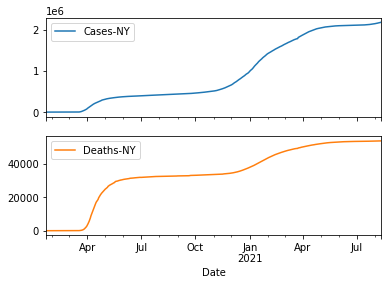

In [272]:
df_cumulative = STATES['NY'].copy()
df_cumulative.plot(subplots=True)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

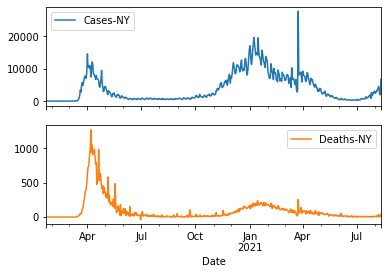

In [273]:
df_diff = STATES['NY'].copy().diff().fillna(0)
df_diff.plot(subplots=True)

### Saving CSVs

In [274]:
import os
# folder = "./data/"
folder = os.path.join(fpath_clean,'state_data/')
os.makedirs(folder,exist_ok=True)
os.listdir(folder)

[]

### Test Join- Maryland Deaths and Cases Data

In [ ]:
# ## Testing md data -  reset index for multi-column join
# md_cases = df_cases_ts.loc['Maryland'].reset_index()
# md_cases

In [ ]:
# ## Testing md data -  reset index for multi-column join
# md_deaths = df_deaths_ts.loc['Maryland'].reset_index()
# md_deaths

In [ ]:
# df_md = pd.merge(md_cases, md_deaths, on=['Date','Admin2'])
# df_md = df_md.set_index("Date").resample('D').sum()

# df_md.plot(subplots=True)

In [ ]:
# df_md_diff = df_md.diff().fillna(0)#.plot(subplots=True)
# df_md_diff.plot(subplots=True)

- 

___

# BOOKMARK - Data.Gov From BEFORE Kaggle

## Data.Gov Hospital Data

### ❌"COVID-19 Reported Patient Impact and Hospital Capacity by State" [NOT TIME SERIES!!!]

- https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/6xf2-c3ie

In [ ]:
# ## JSON way - From https://dev.socrata.com/foundry/healthdata.gov/6xf2-c3ie

# #!/usr/bin/env python

# # make sure to install these packages before running:
# # pip install pandas
# # pip install sodapy

# import pandas as pd
# from sodapy import Socrata

# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("healthdata.gov", None)

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(healthdata.gov,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# results = client.get("6xf2-c3ie", limit=2000)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)
# results_df

In [ ]:
# ## CSV way
# url ="https://healthdata.gov/resource/6xf2-c3ie.csv"
# df0 = pd.read_csv(url,parse_dates=True)
# df0


In [ ]:
# df0.info()

In [ ]:
# df0.nunique()

### `"COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries API"`
- https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

- API URL (csv): https://healthdata.gov/resource/g62h-syeh.csv
- ~~geojson url: https://healthdata.gov/resource/g62h-syeh.geojson~~

In [36]:
df1_downloaded = pd.read_csv('/Users/jamesirving/Downloads/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries.csv')
df1_downloaded

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,...,adult_icu_bed_utilization_denominator,geocoded_state,previous_day_admission_adult_covid_confirmed_18-19,previous_day_admission_adult_covid_confirmed_18-19_coverage,previous_day_admission_adult_covid_confirmed_20-29,previous_day_admission_adult_covid_confirmed_20-29_coverage,previous_day_admission_adult_covid_confirmed_30-39,previous_day_admission_adult_covid_confirmed_30-39_coverage,previous_day_admission_adult_covid_confirmed_40-49,previous_day_admission_adult_covid_confirmed_40-49_coverage,previous_day_admission_adult_covid_confirmed_50-59,previous_day_admission_adult_covid_confirmed_50-59_coverage,previous_day_admission_adult_covid_confirmed_60-69,previous_day_admission_adult_covid_confirmed_60-69_coverage,previous_day_admission_adult_covid_confirmed_70-79,previous_day_admission_adult_covid_confirmed_70-79_coverage,previous_day_admission_adult_covid_confirmed_80+,previous_day_admission_adult_covid_confirmed_80+_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18-19,previous_day_admission_adult_covid_suspected_18-19_coverage,previous_day_admission_adult_covid_suspected_20-29,previous_day_admission_adult_covid_suspected_20-29_coverage,previous_day_admission_adult_covid_suspected_30-39,previous_day_admission_adult_covid_suspected_30-39_coverage,previous_day_admission_adult_covid_suspected_40-49,previous_day_admission_adult_covid_suspected_40-49_coverage,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_50-59_coverage,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_60-69_coverage,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_70-79_coverage,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_80+_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage
0,PR,2020/07/27,1,1,55,1,1,55,0.0,4,8118.0,54,4245.0,57,514.0,56,NaN,0,0.0,1,NaN,0,5.0,1,0.0,3,0.0,3,0.0,3,0.0,3,0.0,2,5.0,3,0.0

### Why do I get more data if I download? Pagination?
- https://dev.socrata.com/docs/paging.html

In [37]:
base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
df1 = pd.read_csv(base_url)
df1['date'] = pd.to_datetime(df1['date'])
df1.sort_values('date')

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,...,adult_icu_bed_utilization_denominator,geocoded_state,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_18_19_coverage,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_20_29_coverage,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_30_39_coverage,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_40_49_coverage,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_50_59_coverage,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_60_69_coverage,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_70_79_coverage,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_80_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18_19,previous_day_admission_adult_covid_suspected_18_19_coverage,previous_day_admission_adult_covid_suspected_20_29,previous_day_admission_adult_covid_suspected_20_29_coverage,previous_day_admission_adult_covid_suspected_30_39,previous_day_admission_adult_covid_suspected_30_39_coverage,previous_day_admission_adult_covid_suspected_40_49,previous_day_admission_adult_covid_suspected_40_49_coverage,previous_day_admission_adult_covid_suspected_50_59,previous_day_admission_adult_covid_suspected_50_59_coverage,previous_day_admission_adult_covid_suspected_60_69,previous_day_admission_adult_covid_suspected_60_69_coverage,previous_day_admission_adult_covid_suspected_70_79,previous_day_admission_adult_covid_suspected_70_79_coverage,previous_day_admission_adult_covid_suspected_80_,previous_day_admission_adult_covid_suspected_80_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage
54,MT,2020-01-03,0,0,1,0,0,1,0.0,1,36.0,1,20.0,1,0.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,

In [41]:
url =base_url+"?$offset=1000"
pd.read_csv(url)

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,...,adult_icu_bed_utilization_denominator,geocoded_state,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_18_19_coverage,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_20_29_coverage,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_30_39_coverage,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_40_49_coverage,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_50_59_coverage,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_60_69_coverage,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_70_79_coverage,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_80_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18_19,previous_day_admission_adult_covid_suspected_18_19_coverage,previous_day_admission_adult_covid_suspected_20_29,previous_day_admission_adult_covid_suspected_20_29_coverage,previous_day_admission_adult_covid_suspected_30_39,previous_day_admission_adult_covid_suspected_30_39_coverage,previous_day_admission_adult_covid_suspected_40_49,previous_day_admission_adult_covid_suspected_40_49_coverage,previous_day_admission_adult_covid_suspected_50_59,previous_day_admission_adult_covid_suspected_50_59_coverage,previous_day_admission_adult_covid_suspected_60_69,previous_day_admission_adult_covid_suspected_60_69_coverage,previous_day_admission_adult_covid_suspected_70_79,previous_day_admission_adult_covid_suspected_70_79_coverage,previous_day_admission_adult_covid_suspected_80_,previous_day_admission_adult_covid_suspected_80_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage
0,WI,2020-06-19T00:00:00.000,0,0,145,0,0,145,87.0,141,12646,141,8298,138,349,142,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,Na

In [21]:
## Getting Hospital Capacity Data
# base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
# df1 = pd.read_csv(base_url)
# df1['date'] = pd.to_datetime(df1['date'])
# df1 = df1.sort_values(['state','date'])
# df1

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,...,adult_icu_bed_utilization_denominator,geocoded_state,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_18_19_coverage,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_20_29_coverage,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_30_39_coverage,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_40_49_coverage,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_50_59_coverage,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_60_69_coverage,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_70_79_coverage,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_80_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18_19,previous_day_admission_adult_covid_suspected_18_19_coverage,previous_day_admission_adult_covid_suspected_20_29,previous_day_admission_adult_covid_suspected_20_29_coverage,previous_day_admission_adult_covid_suspected_30_39,previous_day_admission_adult_covid_suspected_30_39_coverage,previous_day_admission_adult_covid_suspected_40_49,previous_day_admission_adult_covid_suspected_40_49_coverage,previous_day_admission_adult_covid_suspected_50_59,previous_day_admission_adult_covid_suspected_50_59_coverage,previous_day_admission_adult_covid_suspected_60_69,previous_day_admission_adult_covid_suspected_60_69_coverage,previous_day_admission_adult_covid_suspected_70_79,previous_day_admission_adult_covid_suspected_70_79_coverage,previous_day_admission_adult_covid_suspected_80_,previous_day_admission_adult_covid_suspected_80_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage
264,AK,2020-04-19,0,0,26,0,0,26,0.0,5,1674.0,26,513.0,26,16.0,5,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,N

### Def Function to Get Pages of Data from HHS

In [ ]:
def get_hospital_data():
    offset = 0
    ## Getting Hospital Capacity Data
    base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
    page = 0
    results = []

    ## seting random, large page-len
    page_len = 1000

    while (page_len>0):
        print(f"[i] Page {page}")
        print(f' - offset = {offset}')
        url = base_url+f"?$offset={offset}"
        df_temp = pd.read_csv(url)
        results.append(df_temp)

        page_len = len(df_temp)
        offset+=page_len
        page+=1
    return pd.concat(results)

# hospital_df = get_hospital_data()
# hospital_df

In [47]:

df1 = get_hospital_data()
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.sort_values(['state','date'])
df1

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,...,adult_icu_bed_utilization_denominator,geocoded_state,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_18_19_coverage,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_20_29_coverage,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_30_39_coverage,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_40_49_coverage,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_50_59_coverage,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_60_69_coverage,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_70_79_coverage,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_80_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18_19,previous_day_admission_adult_covid_suspected_18_19_coverage,previous_day_admission_adult_covid_suspected_20_29,previous_day_admission_adult_covid_suspected_20_29_coverage,previous_day_admission_adult_covid_suspected_30_39,previous_day_admission_adult_covid_suspected_30_39_coverage,previous_day_admission_adult_covid_suspected_40_49,previous_day_admission_adult_covid_suspected_40_49_coverage,previous_day_admission_adult_covid_suspected_50_59,previous_day_admission_adult_covid_suspected_50_59_coverage,previous_day_admission_adult_covid_suspected_60_69,previous_day_admission_adult_covid_suspected_60_69_coverage,previous_day_admission_adult_covid_suspected_70_79,previous_day_admission_adult_covid_suspected_70_79_coverage,previous_day_admission_adult_covid_suspected_80_,previous_day_admission_adult_covid_suspected_80_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage
667,AK,2020-03-23,0,0,1,0,0,1,0.0,1,56.0,1,21.0,1,3.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...

In [22]:
[c for c in df1.columns if 'vent' in c]

[]

In [23]:
unique_states_hospitals = df1['state'].unique()
unique_states_hospitals

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [24]:
# df1 = df1.set_index(['state','date'])
# df1

- Need to reconcile what dates are and are not included

In [25]:
# md = df1.loc['MD']
# # md = md.set_index('date').sort_index(ascending=False)
# md

In [27]:
## Dropping cols with # hospitals reporting ('coverage')
coverage_cols = [c for c in df1.columns if "coverage" in c]
df1.drop(columns=coverage_cols,inplace=True)

#### [Column Notes](https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh)
- General Naming Schemes:
    - "...coverage" columns:
        - coverage columns seem to all represent # of hospitals reporting for that stat. 
    - "...utilization" columns:
        - seem to be the metrics I am looking for
            - have "utilization",+'_denominator'+'numerator" columns for each
    
    
    
- Groups of columns:
    - "critical_staffing_shortage" columns:
        - "critical_staffing_shortage_today"...
            - yes, no, not_reported
        - "critical_staffing_anticipated_within_week"....
            - yes,no,not_reported
    - "hospital_onset"...
    - "inpatient_beds"...
    - "previous_day_admission"..
        

### Columns to find from the covid tracking project dataset: 

- Old: "hospitalizedCurrently"/"hospitalizedCumulative"
    - New: "inpatient_beds_utilization"
- "inIcuCurrently","inIcuCumulative"
    - New: "adult_icu_bed_utilization
- "onVentilatorCurrently","onVentilatorCumulative"

In [33]:
## collecting lists of colun names (see md cell above with notes )

## unneeded cols
staffing_cols = [c for c in df1.columns if "staffing" in c]
previous_day_cols = [c for c in df1.columns if "previous_day" in c]


## unsure/raw util cols
raw_inpatient_beds =  ['inpatient_beds','inpatient_beds_used','inpatient_beds_used_covid']


## needed cols (utilization )
inpatient_bed_util_cols = [c for c in df1.columns if 'inpatient_beds_utilization' in c]
adult_icu_util_cols = [c for c in df1.columns if 'adult_icu_bed_utilization'in c]



## COMBINING ABOVE LISTS INTO DROP AND KEEP LISTS
DROP_COLS = [*staffing_cols,*previous_day_cols]
UNSURE_COLS = [*raw_inpatient_beds]

KEEP_COLS = ['date','state',*inpatient_bed_util_cols,*adult_icu_util_cols]
KEEP_COLS

['date',
 'state',
 'inpatient_beds_utilization',
 'inpatient_beds_utilization_coverage',
 'inpatient_beds_utilization_numerator',
 'inpatient_beds_utilization_denominator',
 'adult_icu_bed_utilization',
 'adult_icu_bed_utilization_coverage',
 'adult_icu_bed_utilization_numerator',
 'adult_icu_bed_utilization_denominator']

In [34]:
## SHOWING UN-CAPTURED COLUMNS
df1.drop(columns=[*DROP_COLS,*KEEP_COLS,*UNSURE_COLS]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   hospital_onset_covid                                                          974 non-null    float64
 1   hospital_onset_covid_coverage                                                 1000 non-null   int64  
 2   inpatient_beds_coverage                                                       1000 non-null   int64  
 3   inpatient_beds_used_coverage                                                  1000 non-null   int64  
 4   inpatient_beds_used_covid_coverage                                            1000 non-null   int64  
 5   staffed_adult_icu_bed_occupancy                                               560 non-null    float64
 6   staffed_adult_icu_bed_occupancy_c

### Making `df_hospitals`

<AxesSubplot:xlabel='date'>

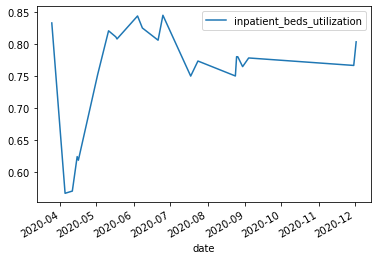

In [35]:
## Making df_hospitals
df_hospitals = df1[KEEP_COLS].copy()
df_hospitals = df_hospitals.set_index(['state','date']).sort_index()
df_hospitals.loc['MD',['inpatient_beds_utilization']].plot()

### Saving My CSVs

### Testing Data using 1 state

In [ ]:
df1['state'].value_counts().sort_index().head(15)

In [ ]:
## Processing 1 state
state = df1.groupby('state').get_group('MD')
state = state.set_index('date').sort_index()
state

In [ ]:
# state = state.resample('D').asfreq()
# state['inpatient_beds'].plot()

#### Notes:
- Contains only 15 rows of data per state (?)
    - Try changing the arguments for the API 
        - [Api Docs[(https://dev.socrata.com/foundry/healthdata.gov/g62h-syeh)
    